In [1]:
# Imports
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()


# Exploratory Precipitation Analysis

In [9]:
# Create a link between inspect and the engine
inspector = inspect(engine)

In [10]:
# Use the inspector tool to find column names in "station" table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Use the inspector tool to find column names in "measurement" table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [68]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

The most recent data point in the database is: 2017-08-23
The most recent data point in the database is: 0.0
The date one year before the most recent date is: 2016-08-23


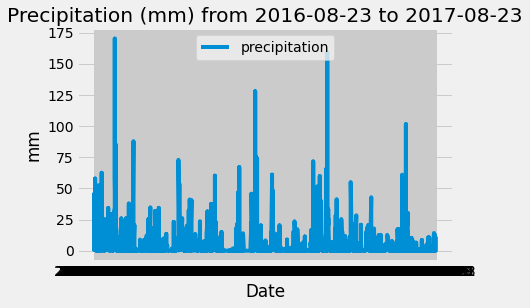

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_data_point = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date == '2017-08-23').first()

for record in most_recent_data_point:
    print(f"The most recent data point in the database is: {record}")
    
# Calculate the date one year from the last date in data set.

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The date one year before the most recent date is: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_list = []
precipitation_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23')

for record in precipitation_data:
    precipitation_list.append(record)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df = pd.DataFrame(precipitation_list, columns=["Date", "Precipitation (ml)"])
precipitation_data_df.set_index("Date")


# Sort the dataframe by date
precipitation_data_df = precipitation_data_df.sort_values(["Date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Start by removing 'Na' entries
precipitation_data_df = precipitation_data_df.dropna(how='any')

# Set x and y values
x_values = precipitation_data_df["Date"]
y_values = precipitation_data_df["Precipitation (ml)"]

plt.title("Precipitation (mm) from 2016-08-23 to 2017-08-23")
plt.xlabel("Date")
plt.ylabel("mm")
plt.plot(x_values, y_values, label="precipitation")
plt.legend(loc="upper center")
plt.savefig("Output/Precipitation Gragh.png")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data_df.describe()

,Precipitation (ml)
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [69]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.id)).all()[0][0]

9

In [72]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
session.query(*sel).group_by(Measurement.station).order_by(desc(func.count(Measurement.id))).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()

print(f"The highest temperature for station USC00519281 is: {highest_temp} degrees celsius")
print(f"The lowest temperature for station USC00519281 is: {lowest_temp} degrees celsius")
print(f"The average temperature for station USC00519281 is: {avg_temp} degrees celsius")

The highest temperature for station USC00519281 is: (29.4,) degrees celsius
The lowest temperature for station USC00519281 is: (12.2,) degrees celsius
The average temperature for station USC00519281 is: (22.03582251082252,) degrees celsius


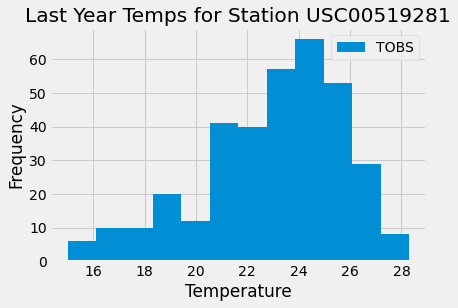

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = []
last_year_query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').filter(Measurement.date <= '2017-08-23').all()

for record in last_year_query:
    last_year_temps.append(record)

last_year_temps_df = pd.DataFrame(last_year_temps, columns=["Date", "Temperature"])
last_year_temps_df

last_year_temps_plot = plt.hist(last_year_temps_df["Temperature"], bins=12, label="TOBS")
plt.title("Last Year Temps for Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.savefig("Output/Last Year Temps for Station USC00519281.png")
plt.show()

# Close session

In [50]:
# Close Session
session.close()